# Import everything

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf

## Data Normalization

In [3]:
df = pd.read_csv('Austin_data.csv', low_memory=False)

Get only the relevant columns

In [4]:
relevant_columns = [
    'property_zip', 'longitude_x', 'latitude_x', 'latitude_y', 'longitude_y','township', 'township_name_x', 'nbhd', 'tract_geoid',
    'tract_pop', 'tract_white_perc', 'commissioner_dist', 'reps_dist',
    'senate_dist', 'ward', 'school_elem_district_x', 'PIN',
    'Property Class', 'Neighborhood Code', 'Land Square Feet', 'Town Code', 'Prior Tax Year Market Value Estimate (Land)',
    'Prior Tax Year Market Value Estimate (Building)', 'Multi Property Indicator', 'Age',
    'Use', 'Multi-Family Indicator', 'Near Major Road', 'Location Factor',
    'Private Service Line Material', 'Public Service Line Material', 'Neigborhood Code (mapping)', 'Town and Neighborhood',
    'property_city'
]

In [ ]:
# Using this to make simpler

# relevant_columns = [
#     'Draw1', 'Draw2', 'Draw3', 'Max', 'longitude', 'latitude',
#     'Private Service Line Material', 'Public Service Line Material'
# ]

In [5]:
df = df[relevant_columns]

In [6]:
# Using only "LEAD" and "NOT LEAD"
df = df[(df['Private Service Line Material'].isin(['LEAD', 'NOT LEAD'])) &
        (df['Public Service Line Material'].isin(['LEAD', 'NOT LEAD']))]


numeric columns with median

In [7]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=[object]).columns

numeric_imputer = SimpleImputer(strategy='median')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])


categorical variables

In [8]:
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

Normalize numeric features

In [9]:
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

-----------------------------------------------------------------------

# **K-means cluster**

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df[relevant_columns].dropna()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


n_clusters = 5  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)


cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_summary = df.groupby('Cluster')[relevant_columns].mean()

print("Cluster Centers:")
print(cluster_centers)
print("\nCluster Summary:")
print(cluster_summary)

Cluster Centers:
[[1.41951992e+02 5.03943954e-01 5.49991846e-01 6.38530208e-01
  5.04050588e-01 9.63861778e-01 3.81970456e+00 1.08953034e-01
  9.26845178e-01 2.61319243e-01 5.56579081e-01 2.74505408e+00
  2.63714060e-01 2.65310384e-01 5.28055168e-01 3.31218676e+01
  4.98903938e-01 8.01484719e-01 3.78583552e-01 1.17996955e-01
  9.64178317e-01 3.44045640e-02 5.62579183e-02 9.89184912e-03
  2.86212134e-01 9.29833817e-02 6.33078343e-03 1.35188605e-01
  6.55284369e-01 9.99340543e-01 9.98153521e-01 3.78583552e-01
  8.16865174e-01 0.00000000e+00]
 [5.28835776e+02 8.13963535e-01 7.86671111e-01 9.12763290e-01
  8.13824354e-01 4.00000000e-01 2.00000000e+00 1.29047019e-02
  3.40433853e-02 2.12689962e-01 8.20076520e-01 3.04522234e+00
  3.80852525e-01 3.77020350e-01 3.97557834e-01 2.90946319e+01
  4.69277107e-01 9.89243030e-01 4.50980572e-02 1.43349816e-01
  4.00000000e-01 4.09551446e-02 8.40702248e-02 8.20701784e-03
  2.37967546e-01 2.39044895e-15 8.41340886e-17 1.86919019e-01
  6.08322124e-01 9.9

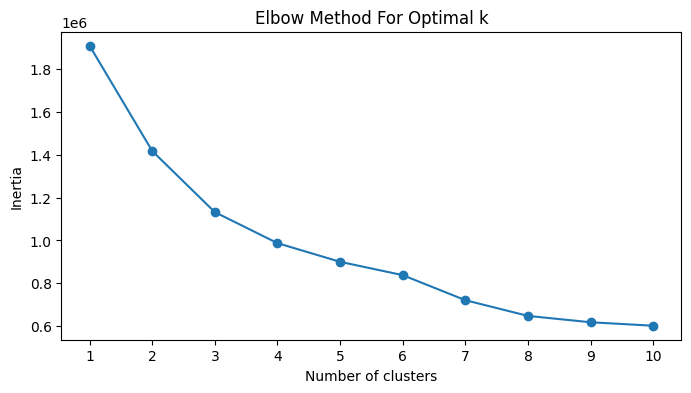

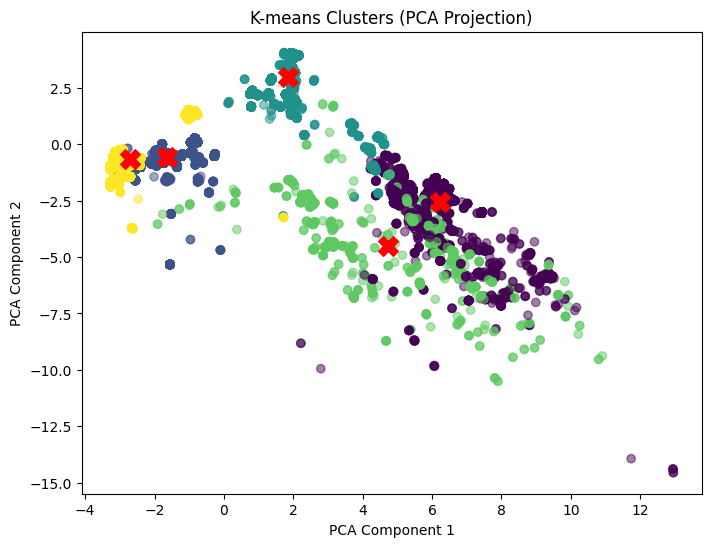

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Diagram 1: Elbow Plot ---
inertias = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)  # using the scaled data
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method For Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.xticks(k_range)
plt.show()

# --- Diagram 2: PCA Projection of Clusters ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

cluster_labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title("K-means Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, marker='X')
plt.show()


In [12]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X)

indices = np.random.choice(range(len(X_scaled)), size=1000, replace=False)
subset = X_scaled[indices]
subset_labels = kmeans.labels_[indices]

print("Unique clusters in subset:", np.unique(subset_labels))

silhouette_avg = silhouette_score(subset, subset_labels)
print(f"Silhouette Score: {silhouette_avg}")

ch_score = calinski_harabasz_score(X, cluster_labels)
print(f"Calinski-Harabasz Score: {ch_score}")

inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)



Unique clusters in subset: [0 1 2 3 4]
Silhouette Score: 0.2842045304517262
Calinski-Harabasz Score: 1729176.1565393503


# **Neural Networks with Dense and Dropout**

In [13]:
X = df.drop(['Private Service Line Material', 'Public Service Line Material'], axis=1)
y_private = df['Private Service Line Material']
y_public = df['Public Service Line Material']

In [17]:
X_train, X_test, y_private_train, y_private_test, y_public_train, y_public_test = train_test_split(
    X, y_private, y_public, test_size=0.2, random_state=42
)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout


y_private_train_cat = to_categorical(y_private_train)
y_private_test_cat = to_categorical(y_private_test)
y_public_train_cat = to_categorical(y_public_train)
y_public_test_cat = to_categorical(y_public_test)

# Define the model
def create_model1(input_shape, output_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Train
private_model = create_model1(X_train.shape[1], y_private_train_cat.shape[1])
public_model = create_model1(X_train.shape[1], y_public_train_cat.shape[1])

private_model.fit(X_train, y_private_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
print("\n--------------------------------------------------------------------------------------------\n")
# public_model.fit(X_train, y_public_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate models
private_pred = private_model.predict(X_test)
public_pred = public_model.predict(X_test)

private_pred_classes = np.argmax(private_pred, axis=1)
public_pred_classes = np.argmax(public_pred, axis=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9759 - loss: 0.4144 - val_accuracy: 0.9925 - val_loss: 0.0374
Epoch 2/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9896 - loss: 0.0629 - val_accuracy: 0.9925 - val_loss: 0.0367
Epoch 3/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9910 - loss: 0.0498 - val_accuracy: 0.9925 - val_loss: 0.0442
Epoch 4/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9906 - loss: 0.0484 - val_accuracy: 0.9925 - val_loss: 0.0462
Epoch 5/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9906 - loss: 0.0489 - val_accuracy: 0.9925 - val_loss: 0.0382
Epoch 6/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9904 - loss: 0.0486 - val_accuracy: 0.9925 - val_loss: 0.0367
Epoch 7/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9913 - loss: 0.0411 - val_accuracy: 0.9925 - val_loss: 0.0334
Epoch 8/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9902 - loss: 0.0415 -

In [18]:
private_loss, private_accuracy = private_model.evaluate(X_test, y_private_test_cat, verbose=0)
print("Private Model Test Accuracy: {:.2f}%".format(private_accuracy * 100))=

public_loss, public_accuracy = public_model.evaluate(X_test, y_public_test_cat, verbose=0)
print("Public Model Test Accuracy: {:.2f}%".format(public_accuracy * 100))


Private Model Test Accuracy: 99.01%
Public Model Test Accuracy: 99.09%


In [ ]:
loss_private, acc_private = private_model.evaluate(X_test, y_private_test_cat, verbose=0)
print("Private Model - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_private, acc_private))

loss_public, acc_public = public_model.evaluate(X_test, y_public_test_cat, verbose=0)
print("Public Model - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_public, acc_public))


# **Neaural Networks model-2**

In [ ]:
def create_model2(input_shape, output_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),  # Increase dropout slightly to prevent overfitting
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Train
private_model = create_model2(X_train.shape[1], y_private_train_cat.shape[1])
public_model = create_model2(X_train.shape[1], y_public_train_cat.shape[1])

private_model.fit(X_train, y_private_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
print("\n--------------------------------------------------------------------------------------------\n")
public_model.fit(X_train, y_public_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate models
private_pred = private_model.predict(X_test)
public_pred = public_model.predict(X_test)

private_pred_classes = np.argmax(private_pred, axis=1)
public_pred_classes = np.argmax(public_pred, axis=1)


In [ ]:
loss_private, acc_private = private_model.evaluate(X_test, y_private_test_cat, verbose=0)
print("Private Model - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_private, acc_private))

loss_public, acc_public = public_model.evaluate(X_test, y_public_test_cat, verbose=0)
print("Public Model - Loss: {:.4f}, Accuracy: {:.4f}".format(loss_public, acc_public))

# **LeakyRelU**

In [ ]:
from keras.layers import LeakyReLU

def create_model3(input_shape, output_shape):
    model = Sequential([
        Dense(128),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),
        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),
        Dense(32),
        LeakyReLU(alpha=0.01),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Train
private_model = create_model3(X_train.shape[1], y_private_train_cat.shape[1])
public_model = create_model3(X_train.shape[1], y_public_train_cat.shape[1])

private_model.fit(X_train, y_private_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
print("\n--------------------------------------------------------------------------------------------\n")
public_model.fit(X_train, y_public_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate models
private_pred = private_model.predict(X_test)
public_pred = public_model.predict(X_test)

private_pred_classes = np.argmax(private_pred, axis=1)
public_pred_classes = np.argmax(public_pred, axis=1)

In [ ]:
# For model one only
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Private Service Line Material Classification Report:")
print(classification_report(y_private_test, private_pred_classes))
print("\nPrivate Service Line Material Confusion Matrix:")
print(confusion_matrix(y_private_test, private_pred_classes))


print("\nPublic Service Line Material Classification Report:")
print(classification_report(y_public_test, public_pred_classes))
print("\nPublic Service Line Material Confusion Matrix:")
print(confusion_matrix(y_public_test, public_pred_classes))

# Function to predict service line material
def predict_service_line(model, X):
    pred = model.predict(X)
    pred_classes = np.argmax(pred, axis=1)
    return le.inverse_transform(pred_classes)

# Example prediction
sample_data = X_test.iloc[:5]  # Take first 5 samples for demonstration
private_predictions = predict_service_line(private_model, sample_data)
public_predictions = predict_service_line(public_model, sample_data)

print("\nSample Predictions:")
print("Private Service Line Material:", private_predictions)
print("Public Service Line Material:", public_predictions)